In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# /content/drive/MyDrive/LeWagon/models

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/LeWagon/data/dataset_multi.zip 

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: dataset_multi/train/rain/2020_09_29_0900_02.jpg  
  inflating: dataset_multi/train/rain/2020_09_29_0900_02_f.jpg  
  inflating: dataset_multi/train/rain/2020_09_29_0900_02_m.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0810_01.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0810_01_m.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0810_02_f.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0810_02_m.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0820_01.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0820_02.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0830_01.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0830_01_m.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0830_02.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0840_01.jpg  
  inflating: dataset_multi/train/rain/2020_10_04_0840_01_f.jpg  
  inflating: dataset_multi/train/rain

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = ResNet50V2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    pred = layers.Dense(4, activation = "softmax")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


Found 18169 images belonging to 4 classes.
Found 2273 images belonging to 4 classes.
Found 2272 images belonging to 4 classes.
Train/test/validation data loaded
94668760/94668760 [==============================] - 6s 0us/step
Model initialised
Model compiled
Epoch 1/40
284/284 [==============================] - 153s 500ms/step - loss: 1.7600 - accuracy: 0.7492 - val_loss: 0.4077 - val_accuracy: 0.8411 - lr: 0.0100
Epoch 2/40
284/284 [==============================] - 134s 471ms/step - loss: 0.4699 - accuracy: 0.8309 - val_loss: 0.3888 - val_accuracy: 0.8640 - lr: 0.0100
Epoch 3/40
284/284 [==============================] - 132s 465ms/step - loss: 0.3969 - accuracy: 0.8614 - val_loss: 0.3921 - val_accuracy: 0.8715 - lr: 0.0100
Epoch 4/40
284/284 [==============================] - 131s 462ms/step - loss: 0.3979 - accuracy: 0.8625 - val_loss: 0.3486 - val_accuracy: 0.8649 - lr: 0.0100
Epoch 5/40
284/284 [==============================] - 129s 452ms/step - loss: 0.3880 - accuracy: 0.8729 -

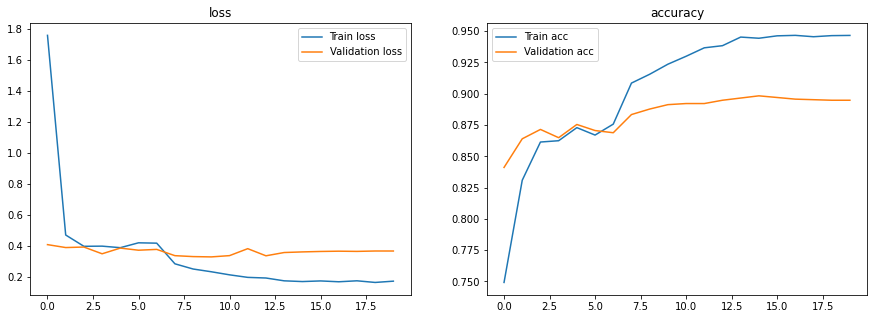

In [ ]:
lr=0.01
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=64
epochs=40

tr="/content/dataset_multi/train"
te="/content/dataset_multi/test"
v="/content/dataset_multi/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = ResNet50V2(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.4)(x)
    pred = layers.Dense(4, activation = "softmax")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


Found 18169 images belonging to 4 classes.
Found 2273 images belonging to 4 classes.
Found 2272 images belonging to 4 classes.
Train/test/validation data loaded
Model initialised
Model compiled
Epoch 1/40
284/284 [==============================] - 134s 462ms/step - loss: 1.6730 - accuracy: 0.6598 - val_loss: 0.4927 - val_accuracy: 0.8248 - lr: 0.0100
Epoch 2/40
284/284 [==============================] - 133s 468ms/step - loss: 0.6833 - accuracy: 0.7603 - val_loss: 0.4109 - val_accuracy: 0.8433 - lr: 0.0100
Epoch 3/40
284/284 [==============================] - 129s 453ms/step - loss: 0.5544 - accuracy: 0.7969 - val_loss: 0.4279 - val_accuracy: 0.8508 - lr: 0.0100
Epoch 4/40
284/284 [==============================] - 136s 479ms/step - loss: 0.5736 - accuracy: 0.8061 - val_loss: 0.4635 - val_accuracy: 0.8349 - lr: 0.0100
Epoch 5/40
284/284 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7943
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583

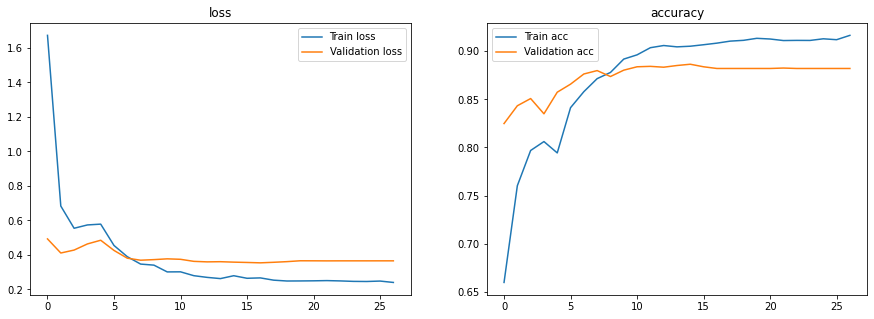

In [ ]:
lr=0.01
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=64
epochs=40

tr="/content/dataset_multi/train"
te="/content/dataset_multi/test"
v="/content/dataset_multi/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)

{'clear': 0, 'cloudy': 1, 'partlycloudy': 2, 'rain': 3}

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import os
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def get_data(train_dir,test_dir,val_dir,batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen=ImageDataGenerator(rescale=1./255)

    #train_datagen_2 = ImageDataGenerator(
    #    rotation_range=40,  # Rotations
    #    width_shift_range=0.2,  # Horinzontal shift
    #    height_shift_range=0.2,  # Vertical shift
    #    rescale=1./255,
    #    shear_range=0.2,  # Transvection (shear mapping)
    #    zoom_range=0.2,  # Zoom
    #    horizontal_flip=True)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='categorical')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 200),
        batch_size=batch_size,
        class_mode='categorical')

    print("Train/test/validation data loaded")
    return (train_generator,validation_generator,test_generator) # val_dir optional

def model_init():

    base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 200, 3))

    x = base_model.output

    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    pred = layers.Dense(4, activation = "softmax")(x)
    base_model.trainable = False
    model = Model(inputs = base_model.input , outputs = pred)

    # We use the keras Functional API to create our keras model

    print("Model initialised")
    return model

def model_compile(model,lr=0.001):
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss='categorical_crossentropy',
              optimizer= adam,
              metrics=['accuracy']) #,f1_m,precision_m, recall_m])
    print("Model compiled")
    return model

def model_fit(model,train_generator,validation_generator,epochs=1):

    MODEL = "model"

    modelCheckpooint = callbacks.ModelCheckpoint("/content/drive/MyDrive/LeWagon/models/{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

    LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

    EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks = [modelCheckpooint, LRreducer, EarlyStopper])

    print("Model fitted")
    return (model,history)

def sv_model(model,history,filename):
    np.save('/content/drive/MyDrive/LeWagon/models/my_history.npy',history.history)
    save_model(model,filename)
    # history=np.load('my_history.npy',allow_pickle='TRUE').item()
    print("model saved")

def ld_model(filename):
    model=load_model(filename)
    print("model loaded")
    return model

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

Found 18169 images belonging to 4 classes.
Found 2273 images belonging to 4 classes.
Found 2272 images belonging to 4 classes.
Train/test/validation data loaded
58889256/58889256 [==============================] - 3s 0us/step
Model initialised
Model compiled
Epoch 1/40
142/142 [==============================] - 147s 979ms/step - loss: 0.8534 - accuracy: 0.6281 - val_loss: 0.5079 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 2/40
142/142 [==============================] - 129s 907ms/step - loss: 0.5428 - accuracy: 0.7679 - val_loss: 0.4793 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 3/40
142/142 [==============================] - 128s 899ms/step - loss: 0.4809 - accuracy: 0.7883 - val_loss: 0.4137 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 4/40
142/142 [==============================] - 128s 902ms/step - loss: 0.4616 - accuracy: 0.7972 - val_loss: 0.4189 - val_accuracy: 0.8002 - lr: 0.0010
Epoch 5/40
142/142 [==============================] - 127s 894ms/step - loss: 0.4520 - accuracy: 0.8021 -

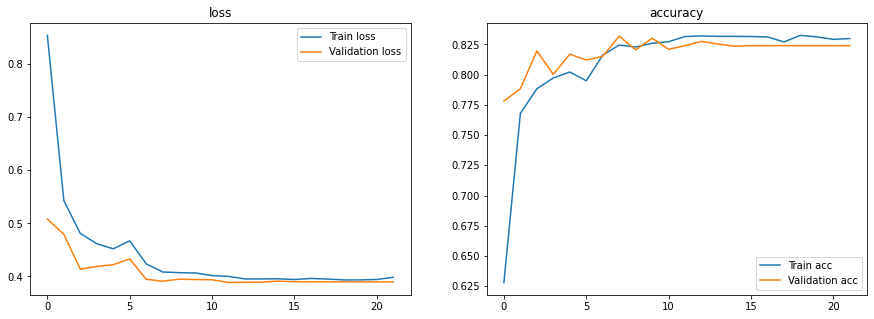

In [ ]:
lr=0.001
filename="/content/drive/MyDrive/LeWagon/models/exportedmodel.h5"
batch_size=128
epochs=40

tr="/content/dataset_multi/train"
te="/content/dataset_multi/test"
v="/content/dataset_multi/val"


(train_generator,validation_generator,test_generator)=get_data(tr,te,v,batch_size)
model=model_init()
model=model_compile(model,lr)
(model,history)=model_fit(model,train_generator,validation_generator,epochs)
model.evaluate(test_generator)
plot_history(history)
sv_model(model,history,filename)